## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

Created for Coursera guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/learn/tweet-emotion-tensorflow)

---

## Task 1: Introduction


## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

In [2]:
pip install numpy --upgrade --ignore-installed

  Using cached numpy-1.23.2-cp38-cp38-win_amd64.whl (14.7 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.4.0 requires daal==2021.3.0, which is not installed.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.23.2 which is incompatible.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.23.2 which is incompatible.
numba 0.55.2 requires numpy<1.23,>=1.18, but you have numpy 1.23.2 which is incompatible.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 1.0.4 which is incompatible.


In [3]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [4]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

C:\Users\Sanket\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Sanket\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\Sanket\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\Sanket\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout

In [6]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sanket\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.9.1


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [9]:
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


In [10]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [11]:
import pandas as pd

In [12]:
df=pd.read_csv('Tweet_emotions.csv')

In [13]:
df.head()

,text,emotions
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,ive probably mentioned this before but i reall...,joy
3,i was feeling a little low few days back,sadness
4,i beleive that i am much more sensitive to oth...,love


In [14]:
df.isnull()

,text,emotions
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
416804,False,False
416805,False,False
416806,False,False
416807,False,False


In [15]:
df=df.dropna()

In [16]:
emotions={'anger': 0, 'joy': 1, 'fear': 2, 'love': 3, 'sadness': 4, 'surprise': 5}

In [17]:
df.emotions = [emotions[item] for item in df.emotions]

In [18]:
df['emotions']

0         4
1         4
2         1
3         4
4         3
         ..
416804    1
416805    2
416806    4
416807    1
416808    4
Name: emotions, Length: 416809, dtype: int64

In [19]:
## Get the Independent Features
X=df.drop('emotions',axis=1)

In [20]:
X.head()

,text
0,i feel awful about it too because it s my job ...
1,im alone i feel awful
2,ive probably mentioned this before but i reall...
3,i was feeling a little low few days back
4,i beleive that i am much more sensitive to oth...


In [21]:
## Get the Dependent features
y=df['emotions']

In [22]:
y[:5]

0    4
1    4
2    1
3    4
4    3
Name: emotions, dtype: int64

In [23]:
df.isnull().sum()

text        0
emotions    0
dtype: int64

In [24]:
messages=X.copy()

In [25]:
mess=X[:200]

In [26]:
messages.head()

,text
0,i feel awful about it too because it s my job ...
1,im alone i feel awful
2,ive probably mentioned this before but i reall...
3,i was feeling a little low few days back
4,i beleive that i am much more sensitive to oth...


In [27]:
import nltk
import re
from nltk.corpus import stopwords

In [28]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sanket\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
len(messages)

416809

## Data Preprocessing 

In [30]:
### Dataset Preprocessing
from nltk.stem.porter import PorterStemmer ##stemming purpose
ps = PorterStemmer()
corpus1 = []
for i in range(0, len(mess)):
    review = re.sub('[^a-zA-Z]', ' ', mess['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus1.append(review)

In [31]:
port_stem = PorterStemmer()

In [32]:
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content 
                       if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [33]:
mess['text'] = mess['text'].apply(stemming)

C:\Users\Sanket\AppData\Local\Temp/ipykernel_5820/1014497956.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mess['text'] = mess['text'].apply(stemming)


In [34]:
### Dataset Preprocessing
from nltk.stem.porter import PorterStemmer ##stemming purpose
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = (messages['text'][i])
    
    corpus.append(review)

In [35]:
corpus

['i feel awful about it too because it s my job to get him in a position to succeed and it just didn t happen here',
 'im alone i feel awful',
 'ive probably mentioned this before but i really do feel proud of myself for actually keeping up with my new years resolution of monthly and weekly goals',
 'i was feeling a little low few days back',
 'i beleive that i am much more sensitive to other peoples feelings and tend to be more compassionate',
 'i find myself frustrated with christians because i feel that there is constantly a talk about loving one another being there for each other and praying for each other and i have seen that this is not always the case',
 'i am one of those people who feels like going to the gym is only worthwhile if you can be there for an hour or more',
 'i feel especially pleased about this as this has been a long time coming',
 'i was struggling with these awful feelings and was saying such sweet things about not deserving my and my sisters friendship and we 

In [36]:
corpus[0]

'i feel awful about it too because it s my job to get him in a position to succeed and it just didn t happen here'

In [37]:
voc_size=50000

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect= TfidfVectorizer().fit(corpus)

In [39]:

X_vectorized=vect.transform(corpus)

In [40]:
print(X_vectorized)

  (0, 67491)	0.20330214861208035
  (0, 67249)	0.1684328972421099
  (0, 63935)	0.39492433579022945
  (0, 50680)	0.32939473416448467
  (0, 43777)	0.11030433471177302
  (0, 35112)	0.15218466476603873
  (0, 34670)	0.2692771516563127
  (0, 33860)	0.365307528581015
  (0, 32065)	0.11867131572476436
  (0, 29933)	0.20102154446681253
  (0, 29650)	0.22105792174052172
  (0, 28760)	0.2901745877297641
  (0, 26461)	0.18021278710547645
  (0, 23283)	0.062007638870880635
  (0, 17316)	0.25759302890274843
  (0, 5651)	0.16112532407096913
  (0, 4479)	0.28528808761730545
  (0, 2384)	0.07973248697620411
  (0, 211)	0.14353168550080442
  (1, 31690)	0.3280671889997729
  (1, 23283)	0.15282732859711637
  (1, 4479)	0.703136212006417
  (1, 1911)	0.6120581626781261
  (2, 74554)	0.20070921096891395
  (2, 73613)	0.11113501620825783
  :	:
  (416807, 67249)	0.06927060547925017
  (416807, 66198)	0.16588016295993957
  (416807, 59005)	0.3700827574876167
  (416807, 48548)	0.40697658560599087
  (416807, 46428)	0.1229520432635

In [41]:
X1=X['text'].values

In [42]:
onehot_repr=[one_hot(words,voc_size)for words in corpus] 
onehot_repr

[[37401,
  20885,
  25147,
  34181,
  28106,
  27420,
  48288,
  28106,
  12742,
  5035,
  26090,
  3325,
  31191,
  29293,
  17720,
  4982,
  4376,
  3325,
  33646,
  38580,
  28106,
  28876,
  49414,
  20709,
  6552,
  17412],
 [13384, 22686, 37401, 20885, 25147],
 [42057,
  45645,
  18257,
  17427,
  11409,
  5306,
  37401,
  7471,
  47387,
  20885,
  8279,
  41144,
  39471,
  6086,
  3389,
  29922,
  46814,
  30639,
  5035,
  12655,
  15375,
  6440,
  41144,
  42985,
  38580,
  38651,
  40698],
 [37401, 34829, 15806, 4982, 33648, 9434, 5135, 15504, 35620],
 [37401,
  28626,
  31891,
  37401,
  9283,
  21058,
  21369,
  20607,
  3325,
  46642,
  38888,
  12357,
  38580,
  21013,
  3325,
  12940,
  21369,
  25304],
 [37401,
  20011,
  39471,
  12977,
  30639,
  36641,
  48288,
  37401,
  20885,
  31891,
  44205,
  39668,
  32638,
  4982,
  9777,
  34181,
  48625,
  22909,
  912,
  34802,
  44205,
  6086,
  33337,
  46642,
  38580,
  21787,
  6086,
  33337,
  46642,
  38580,
  37401,


In [43]:
corpus[1]

'im alone i feel awful'

In [44]:
onehot_repr[1]

[13384, 22686, 37401, 20885, 25147]

In [45]:
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='post',maxlen=sent_length)
print(embedded_docs)

[[48288 28106 12742 ... 20709  6552 17412]
 [13384 22686 37401 ...     0     0     0]
 [ 7471 47387 20885 ... 38580 38651 40698]
 ...
 [37401 28876 28932 ...     0     0     0]
 [13384 15806 21369 ... 35620 49437 31035]
 [37401 43442 46228 ...     0     0     0]]


In [46]:
embedded_docs[1]

array([13384, 22686, 37401, 20885, 25147,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0])

In [47]:
## Creating model
embedding_vector_features=40 ##features representation
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 40)            2000000   
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 2,056,501
Trainable params: 2,056,501
Non-trainable params: 0
_________________________________________________________________
None


In [48]:

## Creating model
embedding_vector_features=40
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Bidirectional(LSTM(100)))
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 40)            2000000   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              112800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 2,113,001
Trainable params: 2,113,001
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
#Creating model
model1=Sequential()
model1.add(Embedding(50000,20))
model1.add(Bidirectional(LSTM(20,return_sequences=True)))
model1.add(Bidirectional(LSTM(20)))
model1.add(Dropout(0.3))
model1.add(Dense(6))
model1.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 20)          1000000   
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 40)         6560      
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 246       
                                                                 
Total params: 1,016,566
Trainable params: 1,016,566
No

In [50]:
len(embedded_docs),y.shape

(416809, (416809,))

In [51]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [52]:
X_final.shape,y_final.shape

((416809, 20), (416809,))

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [54]:
X_train.shape

(279262, 20)

In [55]:
X_test.shape

(137547, 20)

In [56]:
X_train2, X_testval, y_train2, y_testval = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [ ]:
history = model.fit(X_train, y_train, epochs =20 , validation_split=0.15)

Epoch 1/20
3739/7418 [==============>...............] - ETA: 4:18:46 - loss: -227.7253 - accuracy: 0.3384

In [57]:
y_train

array([4, 1, 4, ..., 5, 0, 5], dtype=int64)

In [58]:
h = model1.fit(
    X_train2, y_train2,
    validation_data=(X_testval, y_testval),
    epochs=20,batch_size=400,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
468/468 [==============================] - 26s 48ms/step - loss: 1.4641 - accuracy: 0.5102 - val_loss: 0.8819 - val_accuracy: 0.7763
Epoch 2/20
468/468 [==============================] - 24s 52ms/step - loss: 0.7577 - accuracy: 0.8077 - val_loss: 0.7334 - val_accuracy: 0.8033
Epoch 3/20
468/468 [==============================] - 25s 54ms/step - loss: 1.5801 - accuracy: 0.3758 - val_loss: 1.7915 - val_accuracy: 0.1513
Epoch 4/20
468/468 [==============================] - 27s 57ms/step - loss: 1.7911 - accuracy: 0.1743 - val_loss: 1.7915 - val_accuracy: 0.1721


In [186]:
model1.evaluate(X_test,y_test)

4299/4299 [==============================] - 12s 3ms/step - loss: 8.4244 - accuracy: 0.3163


[8.424367904663086, 0.3163209557533264]

In [99]:
dataset.values()

dict_values([Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000), Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000), Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)])

In [103]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [104]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [105]:
tweets, labels = get_tweets(train)

In [106]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

In [107]:
tweets[3], labels[3]

('i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'love')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [108]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [109]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

tokenizer.fit_on_texts(tweets)

print(tokenizer.texts_to_sequences([tweets[0]]))

[[2, 139, 3, 679]]


In [110]:
print(tokenizer.texts_to_sequences([tweets[3]]))

[[2, 24, 165, 8, 665, 27, 6, 4158, 2, 59, 47, 9, 13, 22, 72, 30, 6, 3497]]


In [111]:
from sklearn.feature_extraction.text import CountVectorizer

In [112]:
cv = CountVectorizer(ngram_range=(1,3), max_features = 5000)
X = cv.fit_transform(tweets).toarray()

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

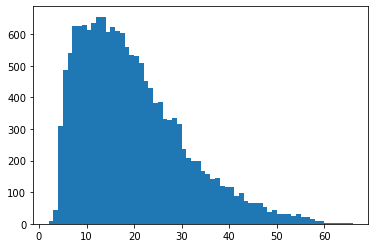

In [113]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [114]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [115]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [116]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [117]:
padded_train_sequences

array([[   2,  139,    3, ...,    0,    0,    0],
       [   2,   40,  101, ...,    0,    0,    0],
       [  17, 3060,    7, ...,    0,    0,    0],
       ...,
       [   2,    3,  327, ...,    0,    0,    0],
       [   2,    3,   14, ...,    0,    0,    0],
       [   2,   47,    7, ...,    0,    0,    0]])

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [118]:
classes = set(labels)
print(classes)

{'love', 'anger', 'surprise', 'fear', 'joy', 'sadness'}


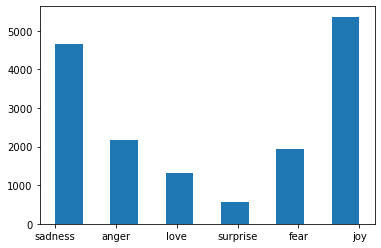

In [119]:
plt.hist(labels, bins=11)
plt.show()

In [120]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [121]:
classes_to_index

{'love': 0, 'anger': 1, 'surprise': 2, 'fear': 3, 'joy': 4, 'sadness': 5}

In [122]:
index_to_classes

{0: 'love', 1: 'anger', 2: 'surprise', 3: 'fear', 4: 'joy', 5: 'sadness'}

In [123]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [124]:
train_labels = names_to_ids(labels)
print(train_labels[0])

5


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [125]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()

In [126]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect= TfidfVectorizer().fit(corpus)

In [127]:
X_vectorized=vect.transform(corpus)

In [128]:
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer()
X_baw = v.fit_transform(corpus)
X_baw

<416809x75276 sparse matrix of type '<class 'numpy.int64'>'
	with 6513003 stored elements in Compressed Sparse Row format>

In [129]:
X_vectorized1=X_vectorized[:5000]
X_baw1=X_baw[:5000]

In [130]:
y1=y[:5000]

In [131]:
corpus[0]

'i feel awful about it too because it s my job to get him in a position to succeed and it just didn t happen here'

In [132]:
v.vocabulary_

{'feel': 23283,
 'awful': 4479,
 'about': 211,
 'it': 33860,
 'too': 67491,
 'because': 5651,
 'my': 43777,
 'job': 34670,
 'to': 67249,
 'get': 26461,
 'him': 29933,
 'in': 32065,
 'position': 50680,
 'succeed': 63935,
 'and': 2384,
 'just': 35112,
 'didn': 17316,
 'happen': 28760,
 'here': 29650,
 'im': 31690,
 'alone': 1911,
 'ive': 33961,
 'probably': 51556,
 'mentioned': 41310,
 'this': 66595,
 'before': 5780,
 'but': 9028,
 'really': 53601,
 'do': 18404,
 'proud': 51958,
 'of': 46106,
 'myself': 43843,
 'for': 24636,
 'actually': 660,
 'keeping': 35610,
 'up': 70518,
 'with': 73613,
 'new': 44763,
 'years': 74554,
 'resolution': 55070,
 'monthly': 42869,
 'weekly': 72679,
 'goals': 27013,
 'was': 72370,
 'feeling': 23308,
 'little': 38344,
 'low': 38993,
 'few': 23541,
 'days': 15815,
 'back': 4665,
 'beleive': 5900,
 'that': 66229,
 'am': 2039,
 'much': 43393,
 'more': 42981,
 'sensitive': 58500,
 'other': 47011,
 'peoples': 48822,
 'feelings': 23318,
 'tend': 65906,
 'be': 5508

In [133]:
X_baw[0].toarray()

array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [136]:
classifier.fit(X_train,y_train)

GaussianNB()

In [137]:
classifier.score(X_test,y_test)

0.33619780874900945

In [188]:
#model11--Simple RNN
model11 =keras.Sequential()
model11.add(layers.Embedding(input_dim=10000, output_dim=64))
model11.add(layers.SimpleRNN(20, return_sequences=True, activation="relu"))
model11.add(layers.SimpleRNN(20, activation="relu"))
model11.add(layers.Dense(6, activation="softmax"))
   

model11.summary()


<IPython.core.display.Javascript object>

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 64)          640000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 20)          1700      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_9 (Dense)             (None, 6)                 126       
                                                                 
Total params: 642,646
Trainable params: 642,646
Non-trainable params: 0
_________________________________________________________________


In [190]:
model11.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model11.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 64)          640000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 20)          1700      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_9 (Dense)             (None, 6)                 126       
                                                                 
Total params: 642,646
Trainable params: 642,646
Non-trainable params: 0
_________________________________________________________________


In [143]:
model1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 20)          1000000   
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 40)         6560      
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 40)                0         
                                                                 
 dense_6 (Dense)             (None, 6)                 246       
                                                                 
Total params: 1,016,566
Trainable params: 1,016,566
No

In [145]:
padded_train_sequences.shape

(16000, 50)

In [146]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_6 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [157]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [158]:
classifier.fit( padded_train_sequences, train_labels)

GaussianNB()

In [159]:
classifier.score(test_sequences, test_labels)

0.227

In [160]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 5)

In [196]:
h = model1.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 13s 25ms/step - loss: 1.6217 - accuracy: 0.4811 - val_loss: 1.7136 - val_accuracy: 0.4470
Epoch 2/20
500/500 [==============================] - 13s 26ms/step - loss: 1.6873 - accuracy: 0.4030 - val_loss: 1.7424 - val_accuracy: 0.3605
Epoch 3/20
500/500 [==============================] - 13s 26ms/step - loss: 1.7351 - accuracy: 0.3320 - val_loss: 1.7792 - val_accuracy: 0.2390


In [195]:
h1 = model11.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=30,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
    ]
)

Epoch 1/30
500/500 [==============================] - 5s 10ms/step - loss: 0.3717 - accuracy: 0.8769 - val_loss: 3.7713 - val_accuracy: 0.2705
Epoch 2/30
500/500 [==============================] - 5s 10ms/step - loss: 0.3490 - accuracy: 0.8863 - val_loss: 3.5406 - val_accuracy: 0.2760
Epoch 3/30
500/500 [==============================] - 5s 10ms/step - loss: 0.3326 - accuracy: 0.8913 - val_loss: 4.3395 - val_accuracy: 0.2720
Epoch 4/30
500/500 [==============================] - 5s 10ms/step - loss: 0.3153 - accuracy: 0.8945 - val_loss: 3.8841 - val_accuracy: 0.2675
Epoch 5/30
500/500 [==============================] - 6s 11ms/step - loss: 0.2944 - accuracy: 0.9042 - val_loss: 4.0507 - val_accuracy: 0.2695
Epoch 6/30
500/500 [==============================] - 6s 11ms/step - loss: 0.2824 - accuracy: 0.9076 - val_loss: 3.2239 - val_accuracy: 0.2890
Epoch 7/30
500/500 [==============================] - 5s 11ms/step - loss: 0.2743 - accuracy: 0.9081 - val_loss: 3.9019 - val_accuracy: 0.2835

In [197]:
h11 = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 11s 21ms/step - loss: 0.0751 - accuracy: 0.9771 - val_loss: 0.3790 - val_accuracy: 0.8930
Epoch 2/20
500/500 [==============================] - 11s 21ms/step - loss: 0.0689 - accuracy: 0.9787 - val_loss: 0.3558 - val_accuracy: 0.8950
Epoch 3/20
500/500 [==============================] - 11s 22ms/step - loss: 0.0550 - accuracy: 0.9826 - val_loss: 0.4024 - val_accuracy: 0.8945
Epoch 4/20
500/500 [==============================] - 11s 21ms/step - loss: 0.0543 - accuracy: 0.9837 - val_loss: 0.3981 - val_accuracy: 0.8920


## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

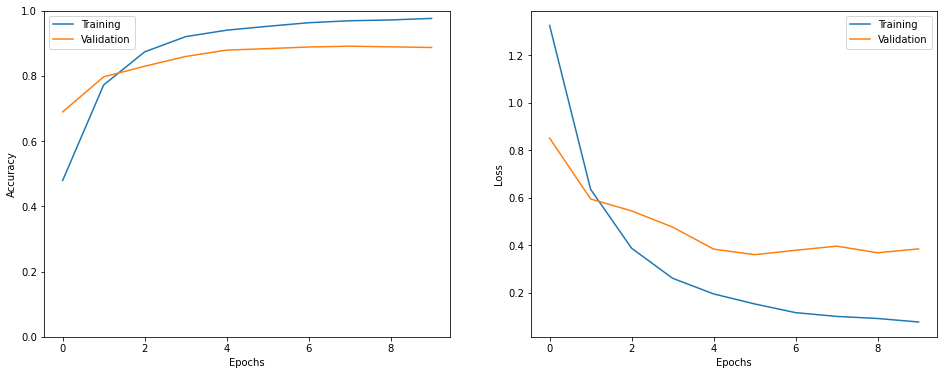

In [154]:
show_history(h)

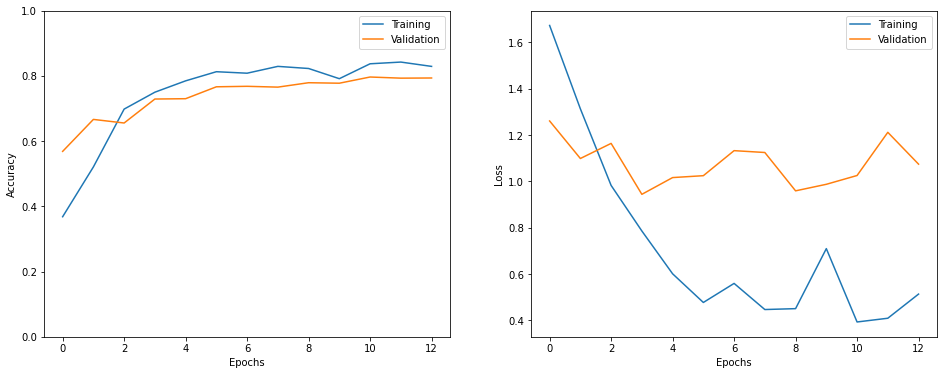

In [155]:
show_history(h1)

In [199]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [209]:
_ = model.evaluate(test_sequences, test_labels)
#For LSTM

63/63 [==============================] - 0s 5ms/step - loss: 0.4138 - accuracy: 0.8845


In [210]:
_ = model11.evaluate(test_sequences, test_labels)
#For RNN

63/63 [==============================] - 0s 3ms/step - loss: 5.9953 - accuracy: 0.2790


In [211]:
#For Nieve bayes
classifier.score(test_sequences, test_labels)

0.227

In [204]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_classes[test_labels[i]])

p = model.predict(np.expand_dims(test_sequences[i], axis=0))[0]
pred_class= index_to_classes[np.argmax(p).astype('uint8')]
print('Predicted Emotion:', pred_class)

Sentence: i feel was pretty triumphant
Emotion: joy
1/1 [==============================] - 0s 18ms/step
Predicted Emotion: joy


In [166]:
preds = (model.predict(test_sequences))

63/63 [==============================] - 0s 5ms/step


In [205]:
preds11 = (model11.predict(test_sequences))

63/63 [==============================] - 0s 3ms/step


In [174]:
preds1 = (model1.predict(test_sequences))

63/63 [==============================] - 1s 5ms/step


In [167]:
preds

array([[1.3542813e-06, 1.6563262e-04, 8.3372481e-07, 1.2205369e-04,
        1.2413606e-04, 9.9958593e-01],
       [3.7640211e-06, 2.0748895e-04, 2.2248300e-06, 1.3277683e-04,
        1.4383186e-04, 9.9950993e-01],
       [1.0281634e-05, 3.3829251e-04, 2.5536692e-06, 1.0097430e-04,
        2.8304741e-04, 9.9926490e-01],
       ...,
       [1.7613912e-04, 2.2068390e-04, 1.6609829e-07, 1.9450126e-05,
        9.9545860e-01, 4.1250046e-03],
       [3.5141487e-04, 9.8984943e-05, 2.2964007e-07, 2.2351373e-05,
        9.9911922e-01, 4.0776169e-04],
       [1.1277630e-03, 8.4199660e-02, 3.1610322e-01, 5.9340841e-01,
        1.0303354e-03, 4.1306298e-03]], dtype=float32)

In [168]:
list(classes)

['love', 'anger', 'surprise', 'fear', 'joy', 'sadness']

In [169]:
arr=[]
for i in preds:
    for j in range(len(i)):
        a=max(i)
        if(a==i[j]):
            arr.append(j)
            break

In [175]:
arr1=[]
for i in preds1:
    for j in range(len(i)):
        a=max(i)
        if(a==i[j]):
            arr1.append(j)
            break

In [206]:
arr11=[]
for i in preds11:
    for j in range(len(i)):
        a=max(i)
        if(a==i[j]):
            arr11.append(j)
            break

In [170]:
test_labels[9]

1

In [171]:
arr[9]

1

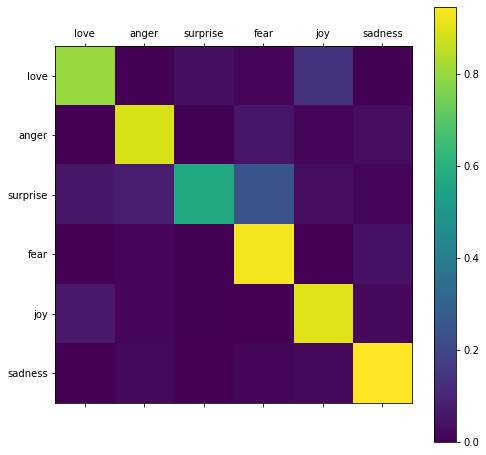

In [172]:
show_confusion_matrix(test_labels, arr, list(classes))

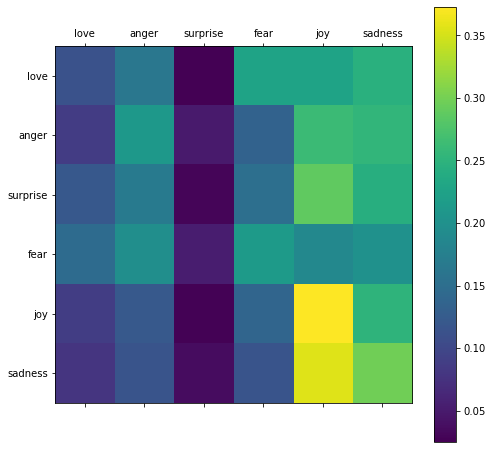

In [207]:
show_confusion_matrix(test_labels, arr11, list(classes))

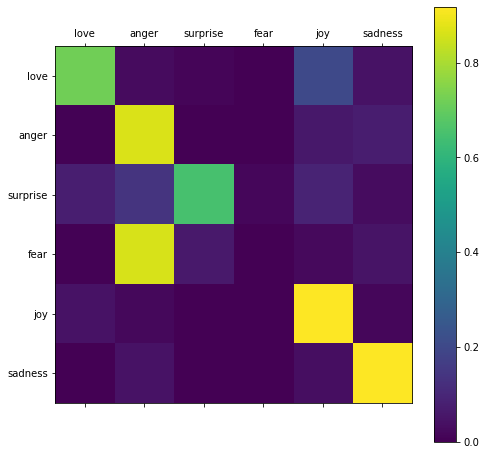

In [177]:
show_confusion_matrix(test_labels, arr1, list(classes))

In [173]:
from sklearn.metrics import confusion_matrix , classification_report
print(classification_report(test_labels,arr))

              precision    recall  f1-score   support

           0       0.72      0.80      0.76       159
           1       0.89      0.89      0.89       275
           2       0.75      0.58      0.65        66
           3       0.84      0.93      0.88       224
           4       0.94      0.90      0.92       695
           5       0.94      0.94      0.94       581

    accuracy                           0.90      2000
   macro avg       0.85      0.84      0.84      2000
weighted avg       0.90      0.90      0.90      2000



In [208]:
from sklearn.metrics import confusion_matrix , classification_report
print(classification_report(test_labels,arr11))

              precision    recall  f1-score   support

           0       0.09      0.11      0.10       159
           1       0.20      0.21      0.20       275
           2       0.03      0.03      0.03        66
           3       0.16      0.21      0.19       224
           4       0.41      0.37      0.39       695
           5       0.33      0.30      0.31       581

    accuracy                           0.28      2000
   macro avg       0.20      0.21      0.20      2000
weighted avg       0.29      0.28      0.28      2000



In [178]:
from sklearn.metrics import confusion_matrix , classification_report
print(classification_report(test_labels,arr1))

              precision    recall  f1-score   support

           0       0.74      0.72      0.73       159
           1       0.49      0.87      0.63       275
           2       0.70      0.65      0.68        66
           3       0.00      0.00      0.00       224
           4       0.89      0.92      0.90       695
           5       0.91      0.92      0.92       581

    accuracy                           0.78      2000
   macro avg       0.62      0.68      0.64      2000
weighted avg       0.72      0.78      0.75      2000

